In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import math
import uproot
import pandas
import numpy as np
import scipy as sp
import numpy.polynomial.chebyshev as cheb
from scipy.optimize import curve_fit
from scipy import stats

import ROOT as r

import zfit
from zfit import z
import tensorflow as tf

Welcome to JupyROOT 6.26/14


/home/belle2/qcampagn/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
import ROOT as r

# Make nice looking plots
plt.rcParams.update({
          'font.size': 20,
          'figure.figsize': (12, 8),
})

In [3]:
# define columns to import
c_1 = ['M','E','dr','dz','theta','isSignal','Mbc','missingMass2OfEvent','recMissM2']

In [4]:
generic_events = uproot.open("b2dsenu_MC_skim.root:antiB0")

In [5]:
df = generic_events.arrays(cut=f'M==M', filter_name=c_1, library='pd')

In [6]:
df.describe()

,M,dr,dz,E,theta,isSignal,Mbc,missingMass2OfEvent,recMissM2
count,2537.000000,2537.000000,2537.000000,2537.000000,2537.000000,2471.000000,2537.000000,2537.000000,2537.000000
mean,3.484741,0.006635,0.006836,4.019447,0.849944,0.320518,5.066255,2.879047,0.104293
std,0.808564,0.010760,0.019472,0.601029,0.477170,0.466770,0.150219,4.466435,0.719995
min,2.100762,0.000022,-0.284194,2.685314,0.012198,0.000000,4.715633,-7.138709,-1.499507
25%,2.736272,0.001905,-0.004707,3.575123,0.490717,0.000000,4.936474,0.039376,-0.378527
50%,3.512623,0.003694,0.006563,3.967167,0.771115,0.000000,5.082570,1.423290,0.100466
75%,4.124883,0.007372,0.017941,4.456379,1.124338,1.000000,5.205185,4.339121,0.624031
max,6.041744,0.247058,0.112193,6.618478,2.763766,1.000000,5.289246,37.293339,1.496928


In [7]:
signal_events = uproot.open("b2dsenu_SM_100k.root:antiB0")

In [8]:
df_sigMC = signal_events.arrays(cut=f'M==M', filter_name=c_1, library='pd')

In [9]:
df_sigMC.describe()

,M,dr,dz,E,theta,isSignal,Mbc,missingMass2OfEvent,recMissM2
count,15909.000000,15909.000000,15909.000000,15909.000000,15909.000000,15657.000000,15909.000000,15909.000000,15909.000000
mean,3.840566,0.003500,0.009213,4.252536,0.779313,0.862234,5.125135,7.230290,-0.040653
std,0.611937,0.004690,0.031950,0.489198,0.467162,0.344665,0.110076,7.517869,0.510314
min,2.106604,0.000005,-0.256062,2.706523,0.001890,0.000000,4.743952,-10.350799,-1.498642
25%,3.416009,0.001172,-0.012720,3.903989,0.436887,1.000000,5.056415,1.872124,-0.393670
50%,3.886040,0.002356,0.009210,4.269557,0.699241,1.000000,5.146096,5.292577,-0.057978
75%,4.304271,0.004395,0.031135,4.613673,1.030323,1.000000,5.213795,10.667090,0.305456
max,5.766494,0.288161,0.167637,6.425998,3.043980,1.000000,5.289242,61.176804,1.496331


In [10]:
def plotVarSimple(var,cuts,nbins,myrange,data,position=0,mylabel="",mytitle = "",log=False):
    
    if mylabel=="":
        mylabel=var

    ax = plt.subplot()

    # define a numpy array from the given column in the dataframe
    npbkg = data.query(cuts+' and isSignal!=1')[var].to_numpy()
    npsig = data.query(cuts+' and isSignal==1')[var].to_numpy()
    
    # create histograms
    ysig, bin_edges = np.histogram(npsig, bins=nbins, range=myrange)
    ax.hist([npbkg,npsig], bins=nbins, range=myrange,
            label=["Background","Signal"], 
            stacked=True)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

    #nsig = df_mc.query(lcmassrangetight+" and "+cuts+' and Lambdac_isSignal==1')[var].to_numpy().size
    #nbkg = df_mc.query(lcmassrangetight+" and "+cuts+' and not Lambdac_isSignal==1')[var].to_numpy().size
    #print(str(nsig)+" signal and "+str(nbkg)+" background -> ",nsig/(nsig+nbkg))
    
    # set plot features
    #plt.ylim(0.1,23000)
    plt.ylim(0.1,None)
    if log==True:
        plt.yscale("log")
    plt.xlim(myrange)
    plt.xlabel(mylabel)
    plt.legend(loc=position)
    ax.set_title(mytitle)
    plt.show()

In [11]:
# Method to overlay fitted pdfs and data sample
def plot_model(model, mydata, nevents, nbins=100, myrange=(-1.5,1.5), mylabel="", mytitle = "", plot_data=True):

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4)
    fig.suptitle(mytitle)

    from matplotlib import gridspec
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    lower, upper = mydata.data_range.limit1d

    x = tf.linspace(lower, upper, num=nbins)  # np.linspace also works
    for mod, frac in zip(model.pdfs, model.params.values()):
        y = mod.pdf(x) * nevents / nbins * mydata.data_range.area()
        y *= frac
        ax0.plot(x, y)
    data_plot = zfit.run(z.unstack_x(mydata))  # we could also use the `to_pandas` method
    y = model.pdf(x) * nevents / nbins * mydata.data_range.area()
    ax0.plot(x, y)

    counts, bin_edges = np.histogram(data_plot, bins=nbins, range=myrange)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    yerrs = counts**0.5
    ax0.errorbar(bin_centers, counts, yerr=yerrs, fmt='k.', linestyle='')
    ax0.set_xlabel(mylabel)
    ax0.set_xlim(myrange)
    ax0.set_ylim(0,None)

    X = np.ma.masked_equal(yerrs,0)
    ypull = (y-counts)/X
    ax1.errorbar(bin_centers, ypull, yerr=ypull*[0], fmt='k.', linestyle='')
    ax1.set_xlim(myrange)
    ax1.set_ylim(-5,5)

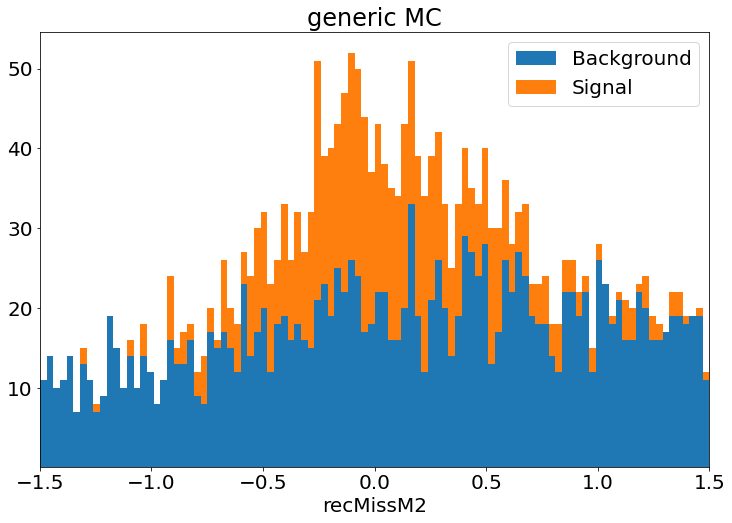

In [12]:
plotVarSimple("recMissM2","Mbc>0",100,(-1.5,1.5),df,mytitle="generic MC")

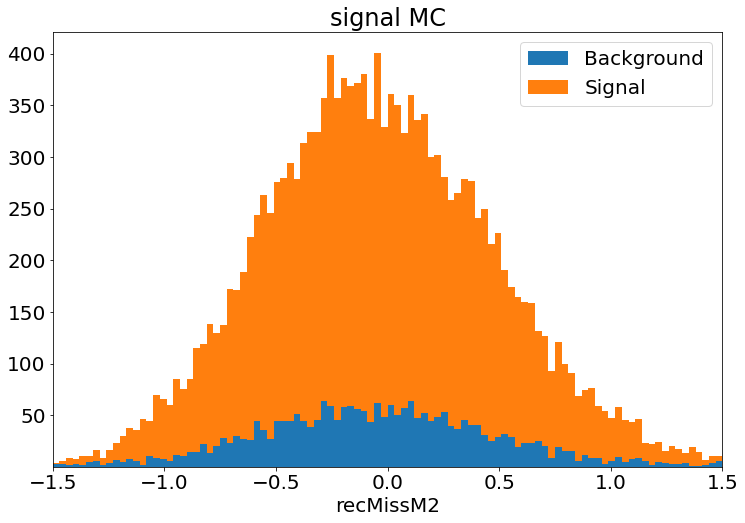

In [13]:
plotVarSimple("recMissM2","Mbc>0",100,(-1.5,1.5),df_sigMC,mytitle="signal MC")

In [14]:
# Define default parameters for zfit
MissM2range = (-1.5,1.5)
MissM2obs = zfit.Space('recMissM2', MissM2range)
issignal = 'isSignal==1'

# Get the signal and background for reference
signal = df.query('Mbc>0 and ' + issignal).recMissM2.to_numpy()
bkg = df.query('Mbc>0 and isSignal!=1').recMissM2.to_numpy()
print('signal: ' + str(len(signal)))
print('bkg: ' + str(len(bkg)))

signal: 792
bkg: 1745


In [15]:
# Signal fit parameters
mu = zfit.Parameter("mu", 0, -1.5, 1.5)
s1 = zfit.param.Parameter("s1", 0.020, 0.0001, 1)

In [16]:
# Build pdf for true signal MC
gaus1 = zfit.pdf.Gauss(obs=MissM2obs, mu=mu, sigma=s1)

sig_sig_yield = zfit.Parameter('sig_sig_yield', 50000, 0, 1e9, step_size=1)

sig_ext = gaus1.create_extended(sig_sig_yield)

In [17]:
# Fill an array with the true signal MC data to be fit
sig_data_np = df_sigMC.query('Mbc>0 and '+issignal).recMissM2.to_numpy()
sig_data = zfit.data.Data.from_numpy(obs=MissM2obs, array=sig_data_np)
sig_data.set_data_range(MissM2range) 
sig_data_size = sig_data.n_events

In [18]:
# Define loss function
nll_simultaneous = zfit.loss.ExtendedUnbinnedNLL(model=sig_ext,data=sig_data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_simultaneous)  
print(result)

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu, s1]] data=[<zfit.core.data.Data object at 0x7f20e96ec6d0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 4.2e-05 │               9958.12 | -3402931 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ------------------  ----------
sig_sig_yield             13500.7       False
mu                     -0.0413584       False
s1                       0.516649       False


In [19]:
sigmean=result.params[mu].get('value')
sigsigma1=result.params[s1].get('value')

In [20]:
# Parameters for misreconstructed signal
sig_mean = zfit.Parameter("sig_mean", sigmean)
sig_mean.floating = False
s2 = zfit.param.Parameter("s2", 0.001, 0.0001, 1)

In [21]:
# Build pdf for misreconstructed signal
gaus2 = zfit.pdf.Gauss(obs=MissM2obs, mu=sig_mean, sigma=s2)

mis_sig_yield = zfit.Parameter('mis_sig_yield', 50000, 0, 1e9, step_size=1)

mis_sig_ext = gaus2.create_extended(mis_sig_yield)

In [22]:
# Fill an array with the misreconstructed signal MC data to be fit
mis_sig_data_np = df_sigMC.query('Mbc>0 and isSignal != 1').recMissM2.to_numpy()
mis_sig_data = zfit.data.Data.from_numpy(obs=MissM2obs, array=mis_sig_data_np)
mis_sig_data.set_data_range(MissM2range) 
mis_sig_data_size = mis_sig_data.n_events

In [23]:
# Define loss function
nll_simultaneous = zfit.loss.ExtendedUnbinnedNLL(model=mis_sig_ext,data=mis_sig_data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_simultaneous)  
print(result)

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[s2, sig_mean]] data=[<zfit.core.data.Data object at 0x7f20fd120880>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 0.00018 │               1861.75 | -1664805 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ------------------  ----------
mis_sig_yield             2409.19       False
s2                       0.538183       False


In [24]:
sigsigma2=result.params[s2].get('value')

In [25]:
# Now we define parameters for fitting the generic MC
sig_s1 = zfit.Parameter("sig_s1", sigsigma1)
sig_s1.floating = False
sig_s2 = zfit.Parameter("sig_s2", sigsigma2)
sig_s2.floating = False

fg1 = zfit.param.Parameter("fg1", 0.20, 0., 1.)
a1 = zfit.Parameter("a1", 0.01, -1e6, 1e6)

sig_yield = zfit.Parameter('sig_yield', 5000, 0, 1e8, step_size=1)
bkg_yield = zfit.Parameter('bkg_yield', 50000, 0, 1e9, step_size=1)

In [34]:
# Build pdf for generic MC
sig_gaus = zfit.pdf.Gauss(obs=MissM2obs, mu=sig_mean, sigma=sig_s1)
bkg_gaus = zfit.pdf.Gauss(obs=MissM2obs, mu=sig_mean, sigma=sig_s2)

#sig_gaus = zfit.pdf.SumPDF(pdfs=[sig_gaus1,sig_gaus2], fracs=[fg1])

bkg_poly = zfit.pdf.Chebyshev(obs=MissM2obs, coeffs=[a1])

bkg_pdf = zfit.pdf.SumPDF(pdfs=[bkg_gaus,bkg_poly], fracs=[fg1])

gen_sig_ext = sig_gaus.create_extended(sig_yield)
gen_bkg_ext = bkg_pdf.create_extended(bkg_yield)

gen_pdf_ext = zfit.pdf.SumPDF(pdfs=[gen_sig_ext,gen_bkg_ext])

In [35]:
# Fill an array with the generic MC data to be fit
gen_data_np = df.query('Mbc>0').recMissM2.to_numpy()
gen_data = zfit.data.Data.from_numpy(obs=MissM2obs, array=gen_data_np)
gen_data.set_data_range(MissM2range)
gen_data_size = gen_data.n_events

In [36]:
# Simultaenous loss
nll_simultaneous = zfit.loss.ExtendedUnbinnedNLL(model=[gen_pdf_ext], data=[gen_data])
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_simultaneous)

In [37]:
result.hesse()
errors, new_result = result.errors()
print(result)

/home/belle2/qcampagn/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_13, Composed_autoparam_14]] data=[<zfit.core.data.Data object at 0x7f20f0ed7340>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 0.00038 │              2596.57 |  9444.395 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name         value  (rounded)        hesse               errors         minuit_minos    at limit
---------  ------------------  -----------  -------------------  -------------------  ----------
sig_yield             1127.01  +/-      70  -4.8e+02   +     62  -4.8e+02   +     62       False
bkg_

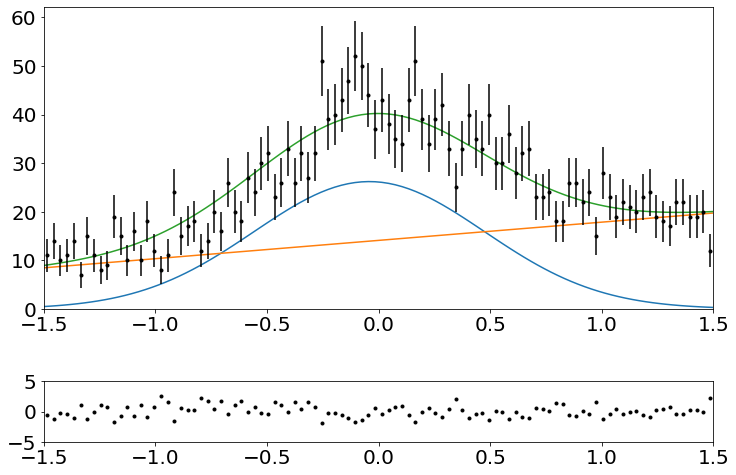

In [38]:
plot_model(model=gen_pdf_ext, mydata=gen_data, nevents=int(gen_data_size), nbins=100)